# Data Cleaning and Exploration

Now we want to clean the dataset and explore the values.

### Libraries

In [ ]:
from pathlib import Path
import shutil
import os
from music21 import converter, note, chord, instrument, meter, tempo, key
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import re
from fractions import Fraction

## Data cleaning


## Checking instrument types

In [ ]:
import os
import pretty_midi

# Path to the directory containing MIDI files
midi_dir = "data_alltogheter"

# Get list of .mid or .midi files (first 100)
midi_files = [f for f in os.listdir(midi_dir) if f.lower().endswith(('.mid', '.midi'))]

# Iterate over each file
for filename in midi_files:
    filepath = os.path.join(midi_dir, filename)
    
    try:
        midi_data = pretty_midi.PrettyMIDI(filepath)
        printed_header = False  # Only print filename if non-piano instrument is found

        for instrument in midi_data.instruments:
            if not instrument.is_drum and instrument.program != 0:
                if not printed_header:
                    print(f"\n--- Processing: {filename} ---")
                    printed_header = True

                name = instrument.name if instrument.name else "Unnamed"
                program = instrument.program
                instrument_name = pretty_midi.program_to_instrument_name(program)
                print(f"Instrument: {instrument_name}, Program: {program}, Name: {name}, Drum: False")

    except Exception as e:
        print(f"Error processing {filename}: {e}")


### Converting fractions

In [ ]:
# Load your CSV
df = pd.read_csv("data_preprocessed/data.csv")

# Step 1: Safe conversion of Fraction(x, y) strings
def safe_eval_fraction(obj):
    try:
        if isinstance(obj, str):
            # Replace all Fraction(x, y) with actual float values
            obj = re.sub(
                r'Fraction\((\d+),\s*(\d+)\)',
                lambda m: str(float(Fraction(int(m.group(1)), int(m.group(2))))),
                obj
            )
            obj = ast.literal_eval(obj)
        return obj
    except Exception as e:
        return None

# Step 2: Convert to rounded float
def convert_duration(value, precision=4):
    try:
        if isinstance(value, list):
            return [round(float(v), precision) for v in value]
        return round(float(value), precision)
    except:
        return None

# Step 3: Full processing function
def process_column(column):
    return [convert_duration(safe_eval_fraction(val)) for val in column]

# Apply to both columns
if 'durations' in df.columns:
    df['durations'] = process_column(df['durations'])

if 'offsets' in df.columns:
    df['offsets'] = process_column(df['offsets'])

# Save once at the end
df.to_csv("data_preprocessed/data.csv", index=False)
print("Updated 'durations' and 'offsets' columns successfully.")


## Preliminary Data Exploration and Cleaning

In [ ]:
df = pd.read_csv("data_preprocessed/data.csv")
print("Columns in your CSV file:")
print(df.columns)

Columns in your CSV file:
Index(['file_name', 'instrument', 'notes', 'chords', 'velocities', 'durations',
       'offsets', 'tempos', 'time_signatures', 'key_signatures',
       'track_names'],
      dtype='object')


In [ ]:
def safe_parse_list_column(column_name):
    parsed = []
    for raw in df[column_name].dropna():
        try:
            parsed_list = ast.literal_eval(raw)
            if isinstance(parsed_list, list):
                parsed.extend(parsed_list)
        except Exception as e:
            print(f"Skipping malformed row in {column_name}: {raw}")
    return parsed

notes = safe_parse_list_column("notes")
durations = safe_parse_list_column("durations")
instruments = safe_parse_list_column("instrument")
tempos = safe_parse_list_column("tempos")
keys = safe_parse_list_column("key_signatures")
times = safe_parse_list_column("time_signatures")
velocities = safe_parse_list_column("velocities")

When trying to safely parse all the columns in the dataset we noticed that for the "durations" column there are some anormaly. We have to fix how the data was saved to be able to use this column.

In [ ]:
def clean_and_parse_list_column(column_name):
    parsed = []
    for raw in df[column_name].dropna():
        if not isinstance(raw, str):
            continue
        raw = raw.strip()
        if not raw.startswith("[") or not raw.endswith("]"):
            continue
        try:
            raw = re.sub(r'^\[|]$', '', raw)
            items = raw.split(",")
            cleaned_items = []
            for item in items:
                item = item.strip().strip("'\"")
                try:
                    val = float(item)
                    cleaned_items.append(val)
                except ValueError:
                    cleaned_items.append(item)
            parsed.extend(cleaned_items)
        except Exception as e:
            print(f"Skipped malformed row: {raw}")
    return parsed


notes = clean_and_parse_list_column("notes")
durations = clean_and_parse_list_column("durations")
instruments = clean_and_parse_list_column("instrument")
tempos = clean_and_parse_list_column("tempos")
keys = clean_and_parse_list_column("key_signatures")
times = clean_and_parse_list_column("time_signatures")
velocities = clean_and_parse_list_column("velocities")


### Notes

In [ ]:
print("Notes:")
print(f"Unique notes: {len(set(notes))}")
print(pd.Series(notes).describe())

Notes:
Unique notes: 88
count    1.831923e+06
mean     6.181524e+01
std      1.393873e+01
min      2.100000e+01
25%      5.200000e+01
50%      6.200000e+01
75%      7.100000e+01
max      1.080000e+02
dtype: float64


### Durations

In [ ]:
print("\nDurations:")
print(pd.Series(durations).describe())
print(df["durations"].head())


Durations:
count     4039871
unique        412
top            3)
freq       852548
dtype: object
0    [0.5, 1.0, 0.75, 0.5, 0.75, 0.25, 2.0, 1.25, 1...
1    [0.25, 2.5, Fraction(5, 3), 0.75, 0.75, Fracti...
2    [2.75, 2.5, 2.25, Fraction(5, 3), Fraction(1, ...
3    [2.0, Fraction(1, 3), 1.0, 0.25, 0.75, 1.5, 0....
4    [1.25, 0.5, Fraction(1, 3), 1.0, 2.25, 1.0, Fr...
Name: durations, dtype: object


In [ ]:
def convert_duration(value, precision=4):
    if isinstance(value, list):
        return [round(float(v), precision) if isinstance(v, Fraction) else round(v, precision) for v in value]
    elif isinstance(value, Fraction):
        return round(float(value), precision)
    try:
        return round(float(value), precision)
    except:
        return None

def process_durations(durations_column):
    cleaned_durations = []
    for item in durations_column:
        try:
            if isinstance(item, str):
                item = eval(item)
            cleaned_durations.append(convert_duration(item))
        except Exception as e:
            cleaned_durations.append(None)
    return cleaned_durations

df['durations'] = process_durations(df['durations'])

print(df['durations'].head())

0    [0.5, 1.0, 0.75, 0.5, 0.75, 0.25, 2.0, 1.25, 1...
1    [0.25, 2.5, 1.6667, 0.75, 0.75, 1.6667, 0.5, 1...
2    [2.75, 2.5, 2.25, 1.6667, 0.3333, 1.0, 0.6667,...
3    [2.0, 0.3333, 1.0, 0.25, 0.75, 1.5, 0.5, 0.5, ...
4    [1.25, 0.5, 0.3333, 1.0, 2.25, 1.0, 2.3333, 2....
Name: durations, dtype: object


### Instruments

In [ ]:
print("\nInstruments:")
print(pd.Series(instruments).value_counts())


Instruments:
Unknown    2093
Name: count, dtype: int64


### Key Signatures

In [ ]:
print("\nKey Signatures:")
print(pd.Series(keys).value_counts())


Key Signatures:
    2093
Name: count, dtype: int64


### Time Signatures

In [ ]:
print("\nTime Signatures:")
print(pd.Series(times).value_counts())


Time Signatures:
4/4    2093
Name: count, dtype: int64


### Tempos

In [ ]:
print("\nTempos:")
print(pd.Series(tempos).describe())


Tempos:
count    2093.0
mean      120.0
std         0.0
min       120.0
25%       120.0
50%       120.0
75%       120.0
max       120.0
dtype: float64


### Velocities

In [ ]:
print("\nVelocities:")
print(pd.Series(velocities).describe())


Velocities:
count    3.036504e+06
mean     5.950470e+01
std      1.008162e+01
min      1.500000e+01
25%      5.200000e+01
50%      6.000000e+01
75%      6.700000e+01
max      8.800000e+01
dtype: float64


In [5]:
print(df.columns.tolist())

['file_name', 'instrument', 'notes', 'chords', 'velocities', 'durations', 'offsets', 'tempos', 'time_signatures', 'key_signatures', 'track_names']


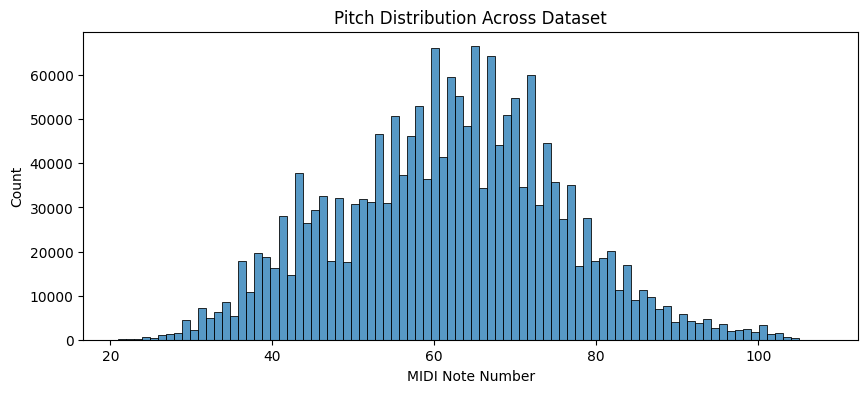

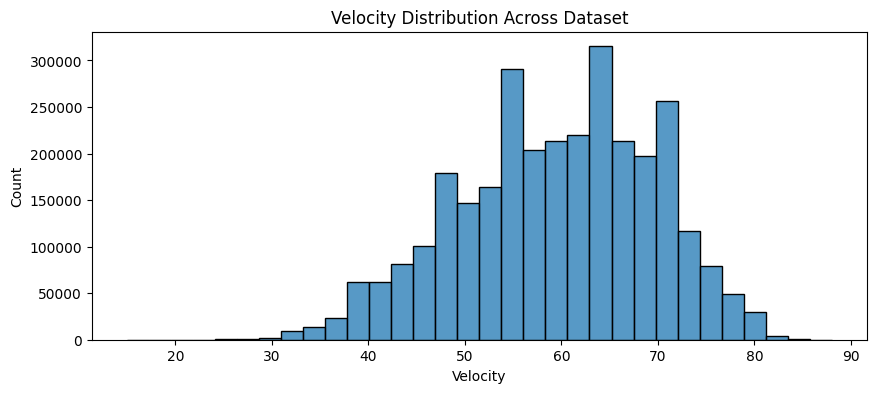

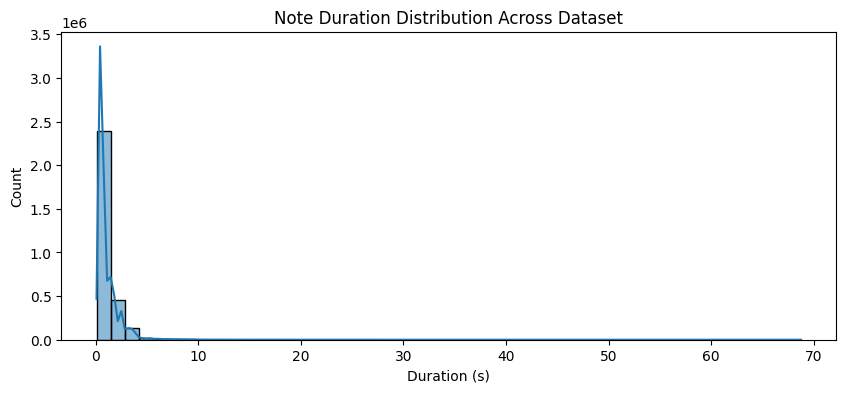

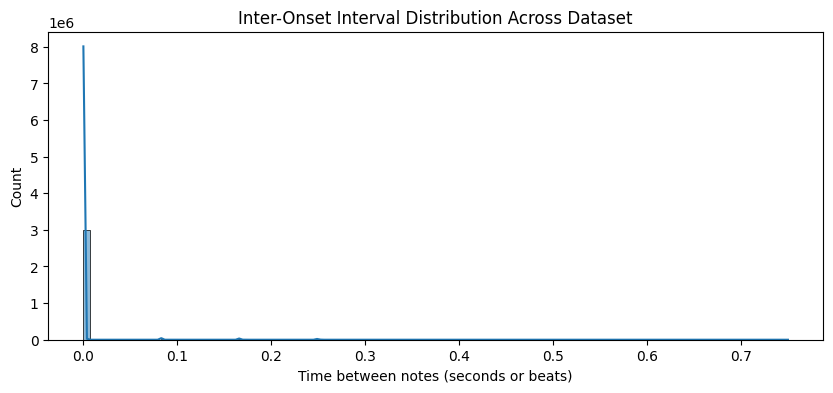

Most common chords: [((60, 63), 2771), ((60, 65), 2720), ((62, 65), 2629), ((58, 63), 2547), ((55, 60), 2526), ((54, 60), 2414), ((60, 64), 2343), ((70, 82), 2307), ((57, 62), 2276), ((72, 84), 2263)]


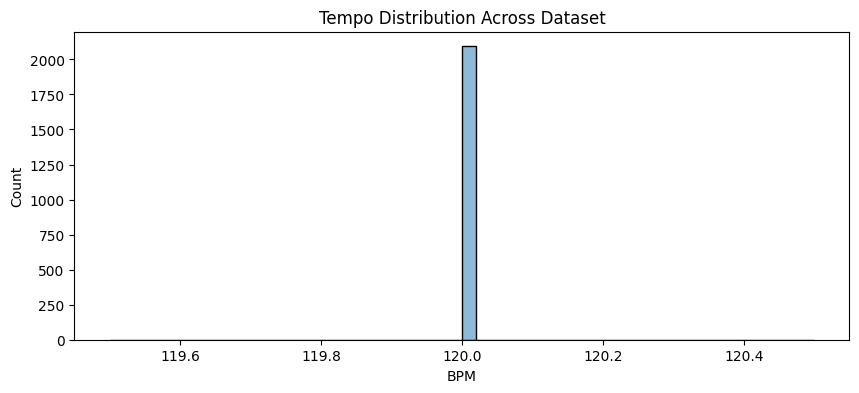

In [10]:
import pandas as pd
import ast  # for safely parsing strings to lists
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data_preprocessed/data.csv')

# Parse columns with list-like strings into actual lists
list_columns = ['notes', 'velocities', 'durations', 'offsets', 'tempos', 'time_signatures', 'key_signatures', 'chords']
for col in list_columns:
    df[col] = df[col].apply(ast.literal_eval)

# Example: flatten all notes across all files into one big list for pitch analysis
all_notes = [note for notes_list in df['notes'] for note in notes_list]
all_velocities = [vel for vel_list in df['velocities'] for vel in vel_list]
all_durations = [dur for dur_list in df['durations'] for dur in dur_list]
all_offsets = [off for off_list in df['offsets'] for off in off_list]

# Plot pitch distribution (MIDI notes)
plt.figure(figsize=(10,4))
sns.histplot(all_notes, bins=88, kde=False)
plt.title('Pitch Distribution Across Dataset')
plt.xlabel('MIDI Note Number')
plt.ylabel('Count')
plt.show()

# Plot velocity distribution
plt.figure(figsize=(10,4))
sns.histplot(all_velocities, bins=32, kde=False)
plt.title('Velocity Distribution Across Dataset')
plt.xlabel('Velocity')
plt.ylabel('Count')
plt.show()

# Plot duration distribution
plt.figure(figsize=(10,4))
sns.histplot(all_durations, bins=50, kde=True)
plt.title('Note Duration Distribution Across Dataset')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

# Inter-onset intervals: Sort offsets and compute diffs per file to get timing between notes
inter_onsets = []
for offsets_list in df['offsets']:
    offsets_list = sorted(offsets_list)
    inter_onsets.extend([j-i for i, j in zip(offsets_list[:-1], offsets_list[1:])])

plt.figure(figsize=(10,4))
sns.histplot(inter_onsets, bins=100, kde=True)
plt.title('Inter-Onset Interval Distribution Across Dataset')
plt.xlabel('Time between notes (seconds or beats)')
plt.ylabel('Count')
plt.show()

# Flatten chords by one level, converting inner lists to tuples
all_chords = []
for chords_list in df['chords']:
    for chord in chords_list:
        # If chord is a list (e.g., [60, 64, 67]), convert to tuple to make it hashable
        if isinstance(chord, list):
            all_chords.append(tuple(chord))
        else:
            all_chords.append(chord)

chord_counts = Counter(all_chords)
print("Most common chords:", chord_counts.most_common(10))

# Optional: Tempo distribution (flatten, removing empty entries)
all_tempos = [tempo for tempo_list in df['tempos'] for tempo in tempo_list if tempo]
plt.figure(figsize=(10,4))
sns.histplot(all_tempos, bins=50, kde=True)
plt.title('Tempo Distribution Across Dataset')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.show()


In [8]:
from collections import Counter

# Flatten chords by one level, converting inner lists to tuples
all_chords = []
for chords_list in df['chords']:
    for chord in chords_list:
        # If chord is a list (e.g., [60, 64, 67]), convert to tuple to make it hashable
        if isinstance(chord, list):
            all_chords.append(tuple(chord))
        else:
            all_chords.append(chord)

chord_counts = Counter(all_chords)
print("Most common chords:", chord_counts.most_common(10))



Most common chords: [((60, 63), 2771), ((60, 65), 2720), ((62, 65), 2629), ((58, 63), 2547), ((55, 60), 2526), ((54, 60), 2414), ((60, 64), 2343), ((70, 82), 2307), ((57, 62), 2276), ((72, 84), 2263)]


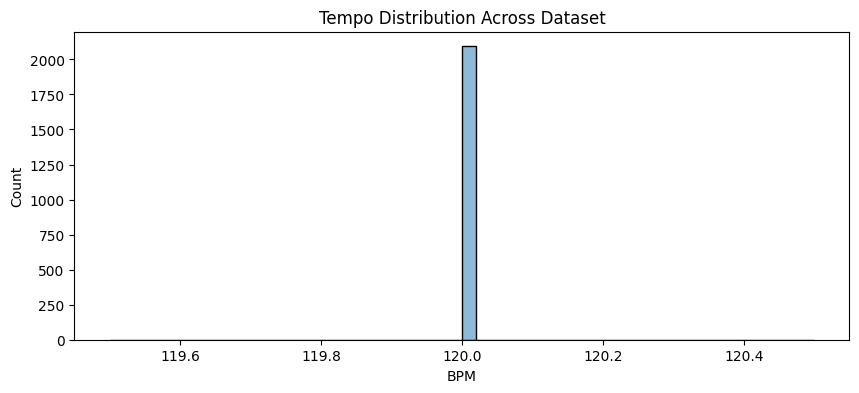

In [9]:
# Optional: Tempo distribution (flatten, removing empty entries)
all_tempos = [tempo for tempo_list in df['tempos'] for tempo in tempo_list if tempo]
plt.figure(figsize=(10,4))
sns.histplot(all_tempos, bins=50, kde=True)
plt.title('Tempo Distribution Across Dataset')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.show()

In [11]:
for i in range(3):
    print(f"Song {i+1} - {df.loc[i, 'file_name']}")
    print("Number of notes:", len(df.loc[i, 'notes']))
    print("Number of chords:", len(df.loc[i, 'chords']))
    print("Number of offsets:", len(df.loc[i, 'offsets']))
    print("Number of durations:", len(df.loc[i, 'durations']))
    print("Example notes and offsets:")
    for n, o in zip(df.loc[i, 'notes'][:5], df.loc[i, 'offsets'][:5]):
        print(f"Note {n} at time {o}")
    print("Example chords:", df.loc[i, 'chords'][:5])
    print('-'*30)


Song 1 - 0_Don't Ask Why - Live At Maybeck Recital Hall  Berkeley, CA.midi
Number of notes: 1219
Number of chords: 760
Number of offsets: 1979
Number of durations: 1979
Example notes and offsets:
Note 48 at time 1.25
Note 49 at time 2.0
Note 54 at time 3.25
Note 56 at time 1.6667
Note 56 at time 3.25
Example chords: [[44, 52], [42, 51], [40, 49], [41, 48, 60], [42, 51]]
------------------------------
Song 2 - 1000_Flight to Jordan.midi
Number of notes: 753
Number of chords: 416
Number of offsets: 1169
Number of durations: 1169
Example notes and offsets:
Note 55 at time 1.25
Note 43 at time 1.5
Note 60 at time 1.5
Note 72 at time 3.25
Note 75 at time 1.5
Example chords: [[36, 51], [43, 63], [60, 72], [59, 71], [62, 74]]
------------------------------
Song 3 - 1001_How Deep Is the Ocean.midi
Number of notes: 685
Number of chords: 537
Number of offsets: 1222
Number of durations: 1222
Example notes and offsets:
Note 36 at time 1.25
Note 43 at time 1.5
Note 48 at time 1.75
Note 50 at time 2

In [12]:
import bisect

def map_notes_to_chords(offsets, notes, chords, chord_offsets):
    """
    Map each note to the chord active at its offset.
    
    Args:
        offsets: list of note start times
        notes: list of note pitches (not directly used here, but could be for info)
        chords: list of chords in time order
        chord_offsets: list of times when chords change (assumed sorted)
        
    Returns:
        List of chords matched to each note
    """
    chord_for_notes = []
    for note_off in offsets:
        # Find rightmost chord offset less than or equal to note offset
        idx = bisect.bisect_right(chord_offsets, note_off) - 1
        if idx >= 0:
            chord_for_notes.append(chords[idx])
        else:
            chord_for_notes.append(None)  # No chord before note
    return chord_for_notes

# Example for first song in your df:
offsets = df.loc[0, 'offsets']
notes = df.loc[0, 'notes']
chords = df.loc[0, 'chords']

# You'll need the times when chords change. 
# If you don't have them explicitly, maybe chord offsets = subset of offsets or another column?
# For now, assume chord_offsets are stored or can be inferred similarly:

# This depends on your dataset structure; often chord offsets are the same as offsets of chords.
# For example, if you have no separate chord offsets, but chord list length == chord offsets length,
# maybe offsets for chords are the offsets column but trimmed or separately stored.

# For now, as an example, let's assume chord_offsets are evenly spaced or you have a list:
chord_offsets = sorted(offsets[:len(chords)])  # Simple guess if no explicit chord offsets available

chords_for_notes = map_notes_to_chords(offsets, notes, chords, chord_offsets)

print(f"First 10 notes with assigned chords:")
for n, c in zip(notes[:10], chords_for_notes[:10]):
    print(f"Note {n} -> Chord {c}")


First 10 notes with assigned chords:
Note 48 -> Chord [72, 74]
Note 49 -> Chord [60, 58]
Note 54 -> Chord [70, 54, 58, 72]
Note 56 -> Chord [56, 61, 66, 70, 73]
Note 56 -> Chord [70, 54, 58, 72]
Note 67 -> Chord [60, 58]
Note 54 -> Chord [60, 63]
Note 56 -> Chord [58, 54, 65, 70]
Note 64 -> Chord [42, 63]
Note 52 -> Chord [95, 101, 97]


In [14]:

df = pd.read_csv('data_preprocessed/data.csv')

# Parse chords column (strings to lists)
df['chords'] = df['chords'].apply(ast.literal_eval)

# Function to sum notes in each chord list
def sum_chord_notes(chords_list):
    return [sum(chord) for chord in chords_list]

# Apply for all songs
df['chord_note_sums'] = df['chords'].apply(sum_chord_notes)

# Example: print first 5 sums for first song
print("Sum of notes in first 5 chords of first song:")
print(df.loc[0, 'chord_note_sums'][:5])


Sum of notes in first 5 chords of first song:
[96, 93, 89, 149, 93]


In [16]:
for i in range(len(df)):
    chords = df.loc[i, 'chords']
    # Assuming each chord is a list of notes
    total_notes_in_chords = sum(len(chord) for chord in chords)
    print(f"Song {i+1} - {df.loc[i, 'file_name']}")
    print("Total number of notes across all chords:", total_notes_in_chords)
    print('-'*30)


Song 1 - 0_Don't Ask Why - Live At Maybeck Recital Hall  Berkeley, CA.midi
Total number of notes across all chords: 1993
------------------------------
Song 2 - 1000_Flight to Jordan.midi
Total number of notes across all chords: 1111
------------------------------
Song 3 - 1001_How Deep Is the Ocean.midi
Total number of notes across all chords: 1571
------------------------------
Song 4 - 1002_It's Only A Paper Moon.midi
Total number of notes across all chords: 1212
------------------------------
Song 5 - 1003_Jor-Du.midi
Total number of notes across all chords: 3282
------------------------------
Song 6 - 1004_Lush Life.midi
Total number of notes across all chords: 1326
------------------------------
Song 7 - 1005_Misty.midi
Total number of notes across all chords: 2157
------------------------------
Song 8 - 1006_Night Walk.midi
Total number of notes across all chords: 2095
------------------------------
Song 9 - 1007_No Problem.midi
Total number of notes across all chords: 1269
----

In [17]:
is_non_decreasing = all(earlier <= later for earlier, later in zip(offsets, offsets[1:]))
print(is_non_decreasing)


False


In [18]:
for i in range(len(offsets) - 1):
    if offsets[i] > offsets[i + 1]:
        print(f"Order fails at index {i} (value {offsets[i]} > {offsets[i+1]})")
        break
else:
    print("Offsets are non-decreasing")


Order fails at index 2 (value 3.25 > 1.6667)


In [24]:
offsets = df.loc[1203, 'offsets']  # get offsets for song i

for idx in range(len(offsets) - 1):
    print(offsets[idx+2])
    print(offsets[idx+1])
    if offsets[idx+1] > offsets[idx + 2]:
        print(f"Order fails at index {idx} (value {offsets[idx]} > {offsets[idx+1]})")
        break
else:
    print("Offsets are strictly increasing")


.
1
Order fails at index 0 (value [ > 1)
